In [2]:
#Data Manipulation
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
import random
#NLP for Chief Complaint
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
#from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

#MachineLearning
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.naive_bayes import GaussianNB


In [3]:
from random import seed
random.seed(37)

In [4]:
nurse_file = "data.csv"
nurse_df = pd.read_csv(nurse_file, sep = ";", encoding='latin-1')

In [5]:
nurse_df.head()

,Group,Sex,Age,Patients number per hour,Arrival mode,Injury,Chief_complain,Mental,Pain,NRS_pain,...,BT,Saturation,KTAS_RN,Diagnosis in ED,Disposition,KTAS_expert,Error_group,Length of stay_min,KTAS duration_min,mistriage
0,2,2,71,3,3,2,right ocular pain,1,1,2,...,36.6,100,2,Corneal abrasion,1,4,2,86,"5,00",1
1,1,1,56,12,3,2,right forearm burn,1,1,2,...,36.5,NaN,4,"Burn of hand, firts degree dorsum",1,5,4,64,"3,95",1
2,2,1,68,8,2,2,"arm pain, Lt",1,1,2,...,36.6,98,4,"Fracture of surgical neck of humerus, closed",2,5,4,862,"1,00",1
3,1,2,71,8,1,1,ascites tapping,1,1,3,...,36.5,NaN,4,Alcoholic liver cirrhosis with ascites,1,5,6,108,"9,83",1
4,1,2,58,4,3,1,"distension, abd",1,1,3,...,36.5,NaN,4,Ascites,1,5,8,109,"6,60",1


In [6]:
nurse_df.columns

Index(['Group', 'Sex', 'Age', 'Patients number per hour', 'Arrival mode',
       'Injury', 'Chief_complain', 'Mental', 'Pain', 'NRS_pain', 'SBP', 'DBP',
       'HR', 'RR', 'BT', 'Saturation', 'KTAS_RN', 'Diagnosis in ED',
       'Disposition', 'KTAS_expert', 'Error_group', 'Length of stay_min',
       'KTAS duration_min', 'mistriage'],
      dtype='object')

In [7]:
nurse_df.dtypes

Group                        int64
Sex                          int64
Age                          int64
Patients number per hour     int64
Arrival mode                 int64
Injury                       int64
Chief_complain              object
Mental                       int64
Pain                         int64
NRS_pain                    object
SBP                         object
DBP                         object
HR                          object
RR                          object
BT                          object
Saturation                  object
KTAS_RN                      int64
Diagnosis in ED             object
Disposition                  int64
KTAS_expert                  int64
Error_group                  int64
Length of stay_min           int64
KTAS duration_min           object
mistriage                    int64
dtype: object

In [8]:
nurse_df.shape

(1267, 24)

Content - Description Available with Original Dataset

https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0216972


Variables:
- Sex: Sex of the patient
- Age: Age of the patient
- Arrival mode: Type of transportation to the hospital
- Injury: Whether the patient is injured or not
- Chief_complain: The patient's complaint
- Mental: The mental state of the patient
- Pain: Whether the patient has pain
- NRS_pain: Nurse's assessment of pain for the patient
- SBP: Systolic Blood Pressure.
- DBP: Diastolic Blood Pressure.
- HR: Heat Rate.
- RR: Respiratory rate
- BT: Body Temperature

The technical document in the project of the data set has been reached. It was seen in this document that some numerical data were actually categorical. These values are as follows:

- Reason Visit : Injury [1 = No, 2= Yes]
- Gender : Sex [1 = Female, 2 = Male]
- Pain : Pain [1 = Yes, 0 = No]
- Mental : Mental status [1 = Alert, 2 = Verbal Response, 3 = Pain Response, 4 = Unresponse]
- Type of ED : Group [1 = Local ED 3th Degree, 2 = Regional ED 4tg Degree]
- Mode of Arrival : Arrival Mode [1 = Walking, 2 = Public Ambulance, 3 = Private Vehicle, 4 = Private Ambulance, 5,6,7 = Other]
- Disposition : Disposition [1 = Dischange, 2 = Admission to ward, 3 = Admission to ICU, 4 = Disharge, 5 = Transfer, 6 = Death, 7 = Surgery]
- KTAS : KTAS… [1,2,3 = Emergency, 4,5 = Non-Emergency]
- Error Group: [1: Vital sign / 2: Physical exam / 3: Psychatric /4: Pain / 5: Mental / 6: Underlying disease / 7: Medical records of other ED / 8: On set / 9: Others] #Method in which the error lead to a mistriage

In [9]:
Gender = ['Female', 'Male']
Injury = [1, 2]

In [10]:
nurse_df['Gender'] = nurse_df['Sex'].apply(lambda row: 1 if row == 2 else 0)
nurse_df['Injury'] = nurse_df['Group'].apply(lambda row: 1 if row == 2 else 0)
nurse_df['NRS_pain'] = nurse_df["NRS_pain"].replace("#BO�!",np.NaN)

In [11]:
def numeric_conversion(column_name):
    new_list = []
    for item in nurse_df[column_name]:
        try:
            item = int(str(item))
        except:
            item = -1
        new_list.append(item)
    nurse_df[column_name] = new_list

def float_conversion(column_name):
    new_list = []
    for item in nurse_df[column_name]:
        try:
            item = float(str(item))
        except:
            item = -1
        new_list.append(item)
    nurse_df[column_name] = new_list
        

In [12]:
wrong_dt_list = ['NRS_pain', 'SBP', 'DBP', 'HR', 'RR', 'Saturation']
for item in wrong_dt_list:
    numeric_conversion(item)

float_conversion('BT')

In [13]:
human_compare = nurse_df[['KTAS_RN', 'KTAS_expert']]

In [14]:
nurse_df[nurse_df['Saturation'] > 0]

,Group,Sex,Age,Patients number per hour,Arrival mode,Injury,Chief_complain,Mental,Pain,NRS_pain,...,Saturation,KTAS_RN,Diagnosis in ED,Disposition,KTAS_expert,Error_group,Length of stay_min,KTAS duration_min,mistriage,Gender
0,2,2,71,3,3,1,right ocular pain,1,1,2,...,100,2,Corneal abrasion,1,4,2,86,"5,00",1,1
2,2,1,68,8,2,1,"arm pain, Lt",1,1,2,...,98,4,"Fracture of surgical neck of humerus, closed",2,5,4,862,"1,00",1,0
5,2,1,54,6,4,1,fever,1,1,3,...,98,3,"Fever, unspecified",2,4,1,9246,"2,00",1,0
6,2,2,49,11,3,1,With chest discomfort,1,1,3,...,98,2,"Angina pectoris, unspecified",1,3,2,400,"3,00",1,1
9,2,1,38,6,3,1,"Eczema, Eyelid",1,1,3,...,97,4,Ocular pain,1,5,4,185,"4,00",1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262,2,2,79,5,2,1,mental change,1,0,-1,...,95,2,Cerebral infarction due to unspecified occlusi...,2,2,0,1995,"3,00",0,1
1263,2,2,81,2,3,1,dysuria,1,0,-1,...,97,4,Dysuria,1,4,0,1000,"2,00",0,1
1264,2,2,81,17,2,1,dizziness,1,0,-1,...,99,3,Dizziness and giddiness,1,3,0,310,"4,00",0,1
1265,2,1,81,2,2,1,"Sensory, Decreased",1,0,-1,...,98,3,"Cord compression, unspecified",7,3,0,475,"5,00",0,0


In [15]:
human_compare.head()

,KTAS_RN,KTAS_expert
0,2,4
1,4,5
2,4,5
3,4,5
4,4,5


In [16]:
human_compare.dtypes

KTAS_RN        int64
KTAS_expert    int64
dtype: object

In [17]:
human_compare['CAT_RN'] = human_compare.loc[:,'KTAS_RN'].apply(lambda x: 1 if x <= 3 else 0)
human_compare['CAT_EXPERT'] = human_compare.loc[:,'KTAS_expert'].apply(lambda x: 1 if x<= 3 else 0)

/var/folders/13/lngr17tj6457_2v2xp487rc40000gn/T/ipykernel_48648/3489706699.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_compare['CAT_RN'] = human_compare.loc[:,'KTAS_RN'].apply(lambda x: 1 if x <= 3 else 0)
/var/folders/13/lngr17tj6457_2v2xp487rc40000gn/T/ipykernel_48648/3489706699.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_compare['CAT_EXPERT'] = human_compare.loc[:,'KTAS_expert'].apply(lambda x: 1 if x<= 3 else 0)


In [18]:
human_compare

,KTAS_RN,KTAS_expert,CAT_RN,CAT_EXPERT
0,2,4,1,0
1,4,5,0,0
2,4,5,0,0
3,4,5,0,0
4,4,5,0,0
...,...,...,...,...
1262,2,2,1,1
1263,4,4,0,0
1264,3,3,1,1
1265,3,3,1,1


Feature Engineering/Selection

In [19]:
nurse_df.columns

Index(['Group', 'Sex', 'Age', 'Patients number per hour', 'Arrival mode',
       'Injury', 'Chief_complain', 'Mental', 'Pain', 'NRS_pain', 'SBP', 'DBP',
       'HR', 'RR', 'BT', 'Saturation', 'KTAS_RN', 'Diagnosis in ED',
       'Disposition', 'KTAS_expert', 'Error_group', 'Length of stay_min',
       'KTAS duration_min', 'mistriage', 'Gender'],
      dtype='object')

In [20]:
features = ['Gender', 'Age', 'Arrival mode', 'NRS_pain', 'Injury', 'Chief_complain', 'Mental', 'Pain', 'SBP', 'DBP', 'HR', 'RR', 'BT', 'Saturation', 'KTAS_expert', 'Diagnosis in ED']

In [21]:
train_df = nurse_df[features]

In [22]:
train_df.head()

,Gender,Age,Arrival mode,NRS_pain,Injury,Chief_complain,Mental,Pain,SBP,DBP,HR,RR,BT,Saturation,KTAS_expert,Diagnosis in ED
0,1,71,3,2,1,right ocular pain,1,1,160,100,84,18,36.6,100,4,Corneal abrasion
1,0,56,3,2,0,right forearm burn,1,1,137,75,60,20,36.5,-1,5,"Burn of hand, firts degree dorsum"
2,0,68,2,2,1,"arm pain, Lt",1,1,130,80,102,20,36.6,98,5,"Fracture of surgical neck of humerus, closed"
3,1,71,1,3,0,ascites tapping,1,1,139,94,88,20,36.5,-1,5,Alcoholic liver cirrhosis with ascites
4,1,58,3,3,0,"distension, abd",1,1,91,67,93,18,36.5,-1,5,Ascites


In [23]:
train_df.dtypes

Gender               int64
Age                  int64
Arrival mode         int64
NRS_pain             int64
Injury               int64
Chief_complain      object
Mental               int64
Pain                 int64
SBP                  int64
DBP                  int64
HR                   int64
RR                   int64
BT                 float64
Saturation           int64
KTAS_expert          int64
Diagnosis in ED     object
dtype: object

In [24]:
train_df.isna().any()

Gender             False
Age                False
Arrival mode       False
NRS_pain           False
Injury             False
Chief_complain     False
Mental             False
Pain               False
SBP                False
DBP                False
HR                 False
RR                 False
BT                 False
Saturation         False
KTAS_expert        False
Diagnosis in ED     True
dtype: bool

In [25]:
train_df.describe()

,Gender,Age,Arrival mode,NRS_pain,Injury,Mental,Pain,SBP,DBP,HR,RR,BT,Saturation,KTAS_expert
count,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000
mean,0.521705,54.423836,2.820837,1.864246,0.456985,1.105762,0.563536,130.992107,77.902131,82.621942,19.150750,36.046725,43.099448,3.265983
std,0.499726,19.725033,0.807904,2.747777,0.498343,0.447768,0.496143,32.866837,19.338546,19.618597,3.343217,4.482012,48.871801,0.885803
min,0.000000,16.000000,1.000000,-1.000000,0.000000,1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000
25%,0.000000,37.000000,2.000000,-1.000000,0.000000,1.000000,0.000000,110.000000,70.000000,72.000000,18.000000,36.200000,-1.000000,3.000000
50%,1.000000,57.000000,3.000000,3.000000,0.000000,1.000000,1.000000,130.000000,80.000000,81.000000,20.000000,36.500000,-1.000000,3.000000
75%,1.000000,71.000000,3.000000,4.000000,1.000000,1.000000,1.000000,150.000000,90.000000,96.000000,20.000000,36.800000,98.000000,4.000000
max,1.000000,96.000000,7.000000,10.000000,1.000000,4.000000,1.000000,275.000000,160.000000,148.000000,30.000000,41.000000,100.000000,5.000000


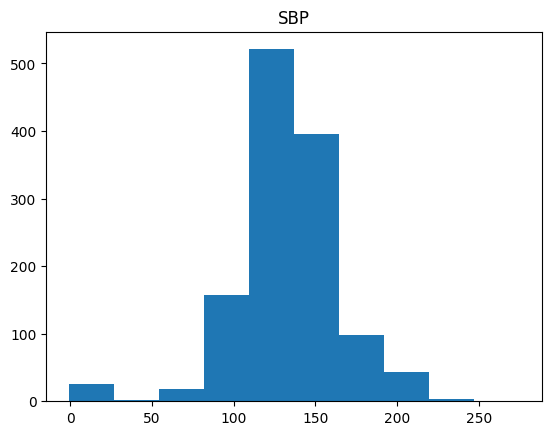

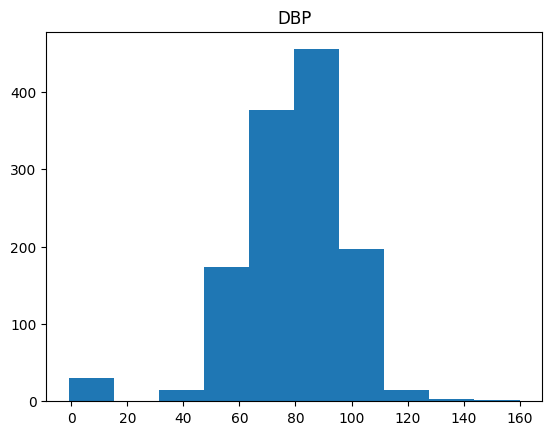

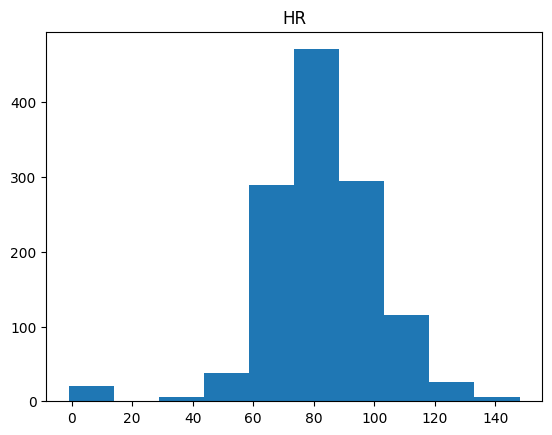

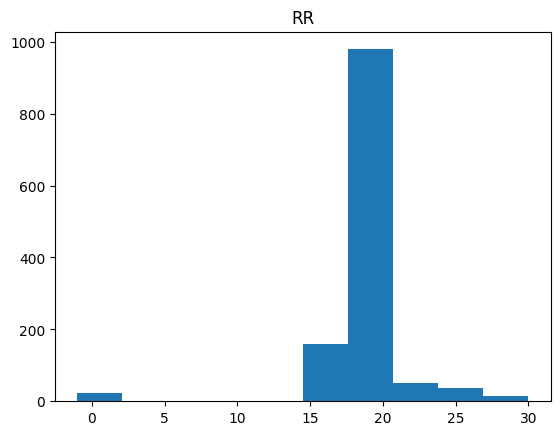

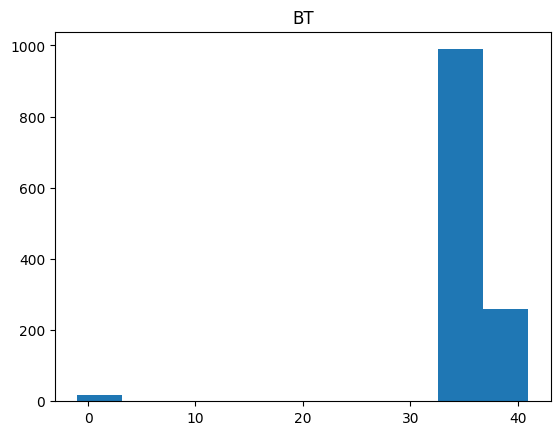

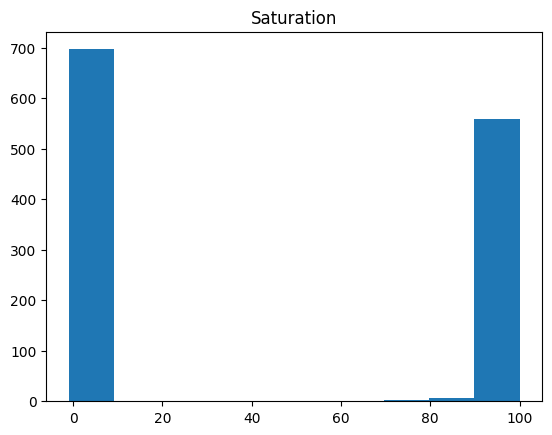

<Figure size 640x480 with 0 Axes>

In [26]:
def distribution_plot(outlier_list):
    for item in outlier_list:
        plt.hist(train_df[item])
        plt.title(str(item))
        plt.show()
        plt.clf()

outliers = ['SBP', 'DBP', 'HR', 'RR', 'BT', 'Saturation']
distribution_plot(outliers)

In [27]:
def neg_replacer(outlist):
    for item in outlist:
        train_df[item].replace(-1, train_df[train_df[item] >= 0][item].mean(), inplace = True)

neg_replacer(outliers)
train_df['NRS_pain'].replace(-1, train_df[train_df['NRS_pain'] >= 0].NRS_pain.median(), inplace = True)

/var/folders/13/lngr17tj6457_2v2xp487rc40000gn/T/ipykernel_48648/3228875152.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[item].replace(-1, train_df[train_df[item] >= 0][item].mean(), inplace = True)
/var/folders/13/lngr17tj6457_2v2xp487rc40000gn/T/ipykernel_48648/3228875152.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['NRS_pain'].replace(-1, train_df[train_df['NRS_pain'] >= 0].NRS_pain.median(), inplace = True)


In [28]:
train_df.describe()

,Gender,Age,Arrival mode,NRS_pain,Injury,Mental,Pain,SBP,DBP,HR,RR,BT,Saturation,KTAS_expert
count,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000
mean,0.521705,54.423836,2.820837,4.058406,0.456985,1.105762,0.563536,133.648953,79.815683,83.963111,19.506827,36.580624,97.024561,3.265983
std,0.499726,19.725033,0.807904,1.064165,0.498343,0.447768,0.496143,27.004987,14.929058,16.512102,1.999050,0.541815,2.916648,0.885803
min,0.000000,16.000000,1.000000,1.000000,0.000000,1.000000,0.000000,50.000000,31.000000,32.000000,14.000000,35.000000,20.000000,1.000000
25%,0.000000,37.000000,2.000000,3.000000,0.000000,1.000000,0.000000,115.000000,70.000000,72.000000,18.000000,36.200000,97.024561,3.000000
50%,1.000000,57.000000,3.000000,4.000000,0.000000,1.000000,1.000000,130.000000,80.000000,82.000000,20.000000,36.500000,97.024561,3.000000
75%,1.000000,71.000000,3.000000,4.000000,1.000000,1.000000,1.000000,150.000000,90.000000,96.000000,20.000000,36.800000,98.000000,4.000000
max,1.000000,96.000000,7.000000,10.000000,1.000000,4.000000,1.000000,275.000000,160.000000,148.000000,30.000000,41.000000,100.000000,5.000000


In [29]:
train_df.dtypes

Gender               int64
Age                  int64
Arrival mode         int64
NRS_pain             int64
Injury               int64
Chief_complain      object
Mental               int64
Pain                 int64
SBP                float64
DBP                float64
HR                 float64
RR                 float64
BT                 float64
Saturation         float64
KTAS_expert          int64
Diagnosis in ED     object
dtype: object

In [30]:
def preprocessing(text):
    text = text.lower()
    tokenwords = nltk.word_tokenize(text)
    stop_words = set(nltk.corpus.stopwords.words('english'))
    lemming = WordNetLemmatizer()
    words = [lemming.lemmatize(word) for word in tokenwords if word.lower() not in stop_words]
    preprocessed_text = ' '.join(words)
    return preprocessed_text


In [31]:
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /Users/sam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [32]:
train_df['Chief_complain'] = train_df['Chief_complain'].apply(preprocessing)

/var/folders/13/lngr17tj6457_2v2xp487rc40000gn/T/ipykernel_48648/3911833675.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Chief_complain'] = train_df['Chief_complain'].apply(preprocessing)


In [33]:
nullvalues = []

nullvalues = []

def append_to_nullvalues(x):
    if type(x) == float:
        nullvalues.append(x)

train_df['Diagnosis in ED'].apply(append_to_nullvalues)

0       None
1       None
2       None
3       None
4       None
        ... 
1262    None
1263    None
1264    None
1265    None
1266    None
Name: Diagnosis in ED, Length: 1267, dtype: object

In [34]:
print(nullvalues)

[nan, nan]


In [35]:
train_df['Diagnosis in ED'] = train_df['Diagnosis in ED'].replace(np.NaN, "Unknown")

/var/folders/13/lngr17tj6457_2v2xp487rc40000gn/T/ipykernel_48648/2311991692.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Diagnosis in ED'] = train_df['Diagnosis in ED'].replace(np.NaN, "Unknown")


In [36]:
train_df['Diagnosis in ED'] = train_df['Diagnosis in ED'].apply(preprocessing)

/var/folders/13/lngr17tj6457_2v2xp487rc40000gn/T/ipykernel_48648/815294157.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Diagnosis in ED'] = train_df['Diagnosis in ED'].apply(preprocessing)


In [37]:
target = train_df['KTAS_expert'].values
print(len(target))
target_c = human_compare['CAT_EXPERT']
print(len(target_c))

1267
1267


In [38]:
train_df = train_df.drop(labels = ["KTAS_expert"], axis=1)

In [39]:
scaler = StandardScaler()

for item in train_df.columns:
        try:
            scaler = StandardScaler()
            new_list = list(train_df[item])
            new_list = np.array(new_list)
            new_list = new_list.reshape(-1, 1)
            scaler.fit(new_list)
            train_df[item] = scaler.transform(new_list)
        except:
            print(str(item) + " is not a num type")


Chief_complain is not a num type
Diagnosis in ED is not a num type


In [40]:
train_df.dtypes

Gender             float64
Age                float64
Arrival mode       float64
NRS_pain           float64
Injury             float64
Chief_complain      object
Mental             float64
Pain               float64
SBP                float64
DBP                float64
HR                 float64
RR                 float64
BT                 float64
Saturation         float64
Diagnosis in ED     object
dtype: object

In [41]:
vector = TfidfVectorizer()
vectorlist = vector.fit_transform(train_df['Chief_complain'])
vector2 = TfidfVectorizer()
vectorlist2 = vector2.fit_transform(train_df['Diagnosis in ED'])

In [42]:
vectorlist

<1267x305 sparse matrix of type '<class 'numpy.float64'>'
	with 2431 stored elements in Compressed Sparse Row format>

In [43]:
testdf = train_df.drop(labels= ["Chief_complain", "Diagnosis in ED"], axis = 1)
training_data = sparse.hstack((vectorlist, testdf))
training_data = sparse.hstack((vectorlist2, training_data))

Train/Test Split

In [44]:
X_train, X_test, y_train, y_test = train_test_split(training_data, target, test_size = 0.2, random_state=3)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(training_data, target_c, test_size = 0.2, random_state=3)

Model Testing Number

Logistic Regression

Random Forest Hyper Parameter Tuning

In [45]:
paramgrid = {'n_estimators': [2, 5, 10, 20, 50, 100, 500], 'min_samples_split':[2, 3, 4, 5], 'min_samples_leaf':[1, 2, 3, 4, 5, 6]}
forest = RandomForestClassifier(random_state=3)
forest_grid = GridSearchCV(estimator=forest, param_grid=paramgrid, refit = True)
forest_grid.fit(X_train, y_train)
forest2 = RandomForestClassifier(random_state=3)
forest_grid2 = GridSearchCV(estimator=forest2, param_grid=paramgrid, refit=True, scoring = 'roc_auc')
forest_grid2.fit(X_train_c, y_train_c)

GridSearchCV(estimator=RandomForestClassifier(random_state=3),
             param_grid={'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [2, 3, 4, 5],
                         'n_estimators': [2, 5, 10, 20, 50, 100, 500]},
             scoring='roc_auc')

In [46]:
print(forest_grid.best_params_)
print(forest_grid2.best_params_)

{'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 500}
{'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}


In [47]:
forest = RandomForestClassifier(min_samples_leaf = 1, min_samples_split = 3, n_estimators = 500, random_state=3)
forest.fit(X_train, y_train)
forest_prediction = forest.predict(X_test)

forest_c = RandomForestClassifier(min_samples_leaf= 1, min_samples_split=5, n_estimators=500, random_state=3)
forest_c.fit(X_train_c, y_train_c)
forest_prediction_c = forest_c.predict(X_test_c)

forest_score = accuracy_score(y_test, forest_prediction)
forest_score_c = accuracy_score(y_test_c, forest_prediction_c)

print(forest_score)
print(forest_score_c)

0.7204724409448819
0.8740157480314961


In [48]:
SVMparam = {'C': [0.1, 1, 10, 100, 1000],
            'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
            'kernel': ['rbf', 'linear', 'poly']}
SVC_ = SVC(random_state=3)
grid = GridSearchCV(SVC_, SVMparam, refit=True, verbose=3)
grid2 = GridSearchCV(SVC_, SVMparam, refit=True, verbose=3, scoring = 'roc_auc')

In [49]:
grid.fit(X_train, y_train)
grid2.fit(X_train_c, y_train_c)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.379 total time=   0.1s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.379 total time=   0.1s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.379 total time=   0.1s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.381 total time=   0.1s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.376 total time=   0.1s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.596 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.621 total time=   0.0s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.650 total time=   0.0s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.609 total time=   0.0s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.639 total time=   0.0s
[CV 1/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.557 total time=   0.1s
[CV 2/5] END .......C=0.1, gamma=1, kernel=poly

GridSearchCV(estimator=SVC(random_state=3),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear', 'poly']},
             scoring='roc_auc', verbose=3)

In [50]:
print(grid.best_params_)
print(grid2.best_params_)

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


In [51]:
vector = SVC(C = 100, gamma= 0.001, kernel='rbf', probability=True, random_state=3)
vector.fit(X_train, y_train)
SVMprediction = vector.predict(X_test)

vector_c = SVC(C = 100, gamma = 0.001, kernel='rbf', probability=True, random_state=3)
vector_c.fit(X_train_c, y_train_c)
SVMprediction_c = vector_c.predict(X_test_c)

SVMscore = accuracy_score(y_test, SVMprediction)
SVMscore_c = accuracy_score(y_test_c, SVMprediction_c)

print(SVMscore)
print(SVMscore_c)

0.6811023622047244
0.84251968503937


Text(0.5, 1.0, 'SVM Emergency Performance')

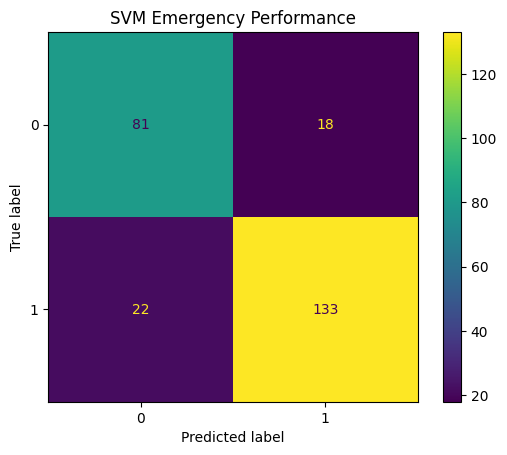

In [52]:
cm1 = confusion_matrix(y_test_c, SVMprediction_c, labels = vector_c.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm1)
disp.plot()
plt.title("SVM Emergency Performance")

Text(0.5, 1.0, 'Forest Emergency Performance')

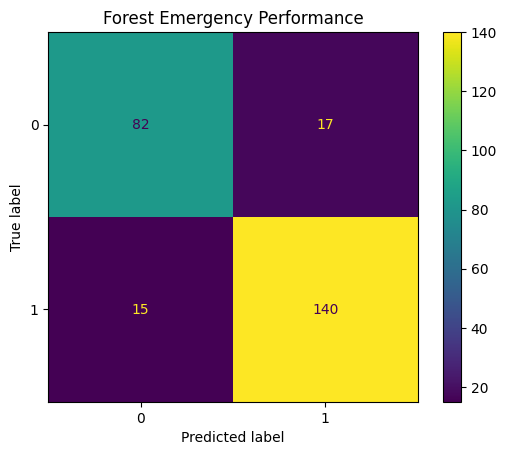

In [53]:
cm2 = confusion_matrix(y_test_c, forest_prediction_c, labels = forest_c.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm2)
disp.plot()
plt.title("Forest Emergency Performance")


Text(0.5, 1.0, 'Nurse Emergency Performance')

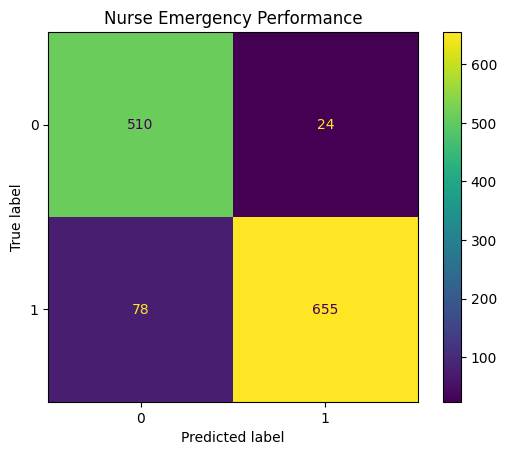

In [54]:
cm3 = confusion_matrix(human_compare['CAT_EXPERT'], human_compare['CAT_RN'], labels = [0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=[0, 1])
disp.plot()
plt.title("Nurse Emergency Performance")

In [55]:
human_compare.columns

Index(['KTAS_RN', 'KTAS_expert', 'CAT_RN', 'CAT_EXPERT'], dtype='object')

In [56]:
len(human_compare[human_compare['KTAS_expert'] == 1])

26

Text(0.5, 1.0, 'Nurse Emergency Performance')

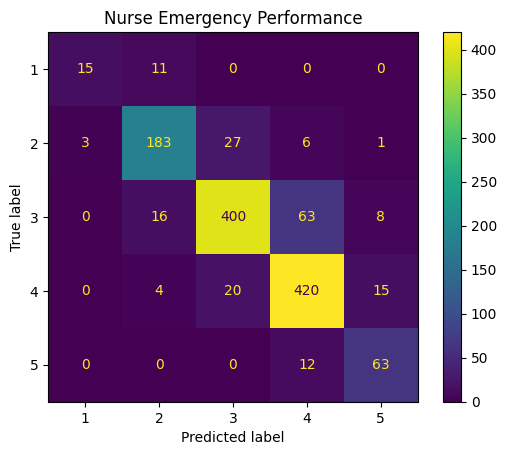

In [57]:
cm4 = confusion_matrix(human_compare['KTAS_expert'], human_compare['KTAS_RN'], labels = [1, 2, 3, 4, 5])
disp = ConfusionMatrixDisplay(confusion_matrix=cm4, display_labels=[1, 2, 3, 4, 5])
disp.plot()
plt.title("Nurse Emergency Performance")

Text(0.5, 1.0, 'Forest Emergency Performance')

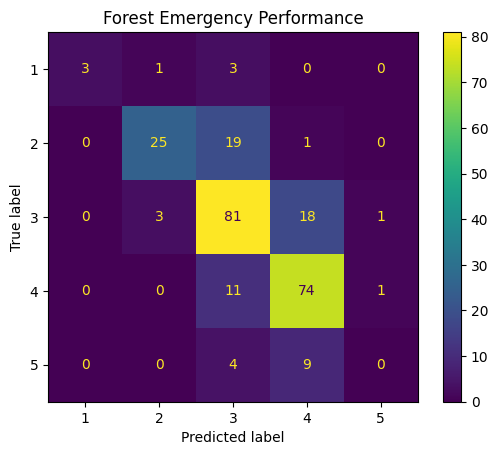

In [58]:
cm5 = confusion_matrix(y_test, forest_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm5, display_labels=[1, 2, 3, 4, 5])
disp.plot()
plt.title("Forest Emergency Performance")

In [59]:
rf_roc = forest_c.predict_proba(X_test_c)
rf_roc = rf_roc[:,1]
rf_auc_score = roc_auc_score(y_test_c, rf_roc)
rf_fpr, rf_tpr, _ = roc_curve(y_test_c, rf_roc)

In [60]:
r_line = [0 for _ in range (len(y_test_c))]
r_auc_score = roc_auc_score(y_test_c, r_line)
r_fpr, r_tpr, _ = roc_curve(y_test_c, r_line)

In [61]:
SM_roc_c = vector_c.predict_proba(X_test_c.toarray())[:, 1]
SM_auc_score = roc_auc_score(y_test_c, SM_roc_c)
SM_fpr, SM_tpr, _ = roc_curve(y_test_c, SM_roc_c)

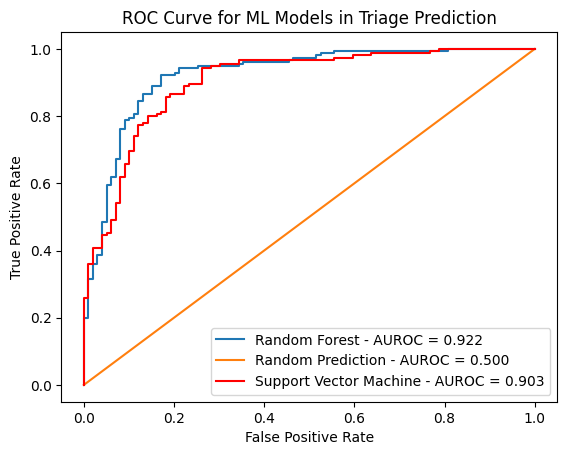

In [62]:
plt.plot(rf_fpr, rf_tpr, label = "Random Forest - AUROC = %0.3f" % rf_auc_score)
plt.plot(r_fpr, r_tpr, label = "Random Prediction - AUROC = %0.3f" % r_auc_score)
plt.plot(SM_fpr, SM_tpr, label = "Support Vector Machine - AUROC = %0.3f" % SM_auc_score, color= 'red')
plt.legend()
plt.title('ROC Curve for ML Models in Triage Prediction')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [63]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import balanced_accuracy_score

In [64]:
nurse_metrics = precision_recall_fscore_support(human_compare['CAT_EXPERT'], human_compare['CAT_RN'])
nurse_ba = balanced_accuracy_score(human_compare['CAT_EXPERT'], human_compare['CAT_RN'])

In [65]:
forest_metrics = precision_recall_fscore_support(y_test_c, forest_prediction_c)
forest_ba = balanced_accuracy_score(y_test_c, forest_prediction_c)
svm_metrics = precision_recall_fscore_support(y_test_c, SVMprediction_c)
svm_ba = balanced_accuracy_score(y_test_c, SVMprediction_c)

In [66]:
print(nurse_metrics)

(array([0.86734694, 0.9646539 ]), array([0.95505618, 0.89358799]), array([0.90909091, 0.92776204]), array([534, 733]))


In [67]:
print(forest_metrics)

(array([0.84536082, 0.89171975]), array([0.82828283, 0.90322581]), array([0.83673469, 0.8974359 ]), array([ 99, 155]))


Text(0.5, 1.0, 'Nurse Emergency Performance')

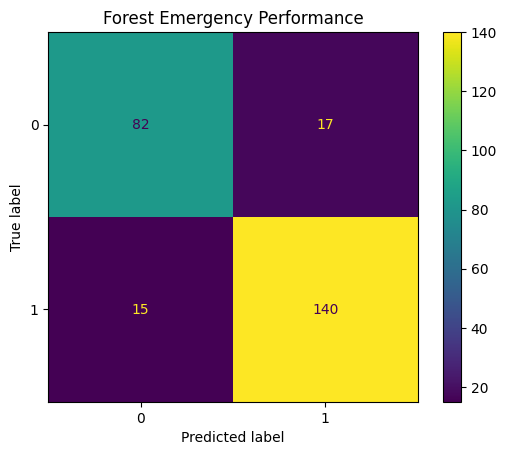

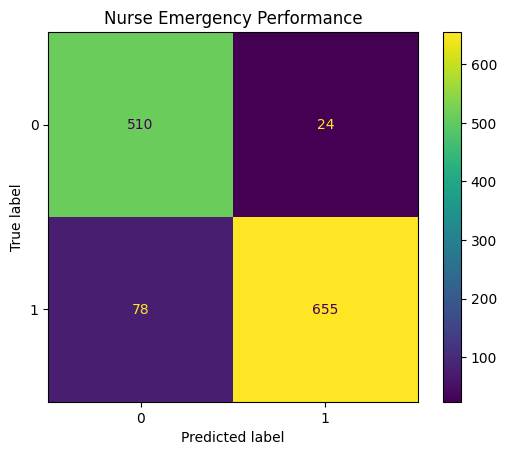

In [68]:
cm2 = confusion_matrix(y_test_c, forest_prediction_c, labels = forest_c.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm2)
disp.plot()
plt.title("Forest Emergency Performance")

cm3 = confusion_matrix(human_compare['CAT_EXPERT'], human_compare['CAT_RN'], labels = [0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=[0, 1])
disp.plot()
plt.title("Nurse Emergency Performance")

In [69]:
prec = [round(nurse_metrics[0][1], 3),round(forest_metrics[0][1], 3), round(svm_metrics[0][1], 3)]
rec = [round(nurse_metrics[1][1],3),round(forest_metrics[1][1],3), round(svm_metrics[1][1], 3)]
f1 = [round(nurse_ba,3),round(forest_ba,3), round(svm_ba, 3)]

In [70]:
index = ['nurse', 'forest', 'SVM']
data = {'index': index,
        'precision': prec,
        'recall': rec,
        'balanced accuracy': f1}

In [71]:
metrics_df = pd.DataFrame(data)

In [72]:
metrics_df

,index,precision,recall,balanced accuracy
0,nurse,0.965,0.894,0.924
1,forest,0.892,0.903,0.866
2,SVM,0.881,0.858,0.838


In [74]:


nurse_multi = balanced_accuracy_score(human_compare['KTAS_expert'], human_compare['KTAS_RN'])

forest_multi = balanced_accuracy_score(y_test, forest_prediction)

SVM_multi = balanced_accuracy_score(y_test, SVMprediction)

In [75]:
print("Nurse Multinomial Classification Balanced Accuracy Score: " + str(round(nurse_multi, 3)))

Nurse Multinomial Classification Balanced Accuracy Score: 0.797


In [76]:
print("Forest Multinomial Classification Balanced Accuracy Score: " + str(round(forest_multi, 3)))

Forest Multinomial Classification Balanced Accuracy Score: 0.526


In [77]:
print("SVM Multinomial Classification Balanced Accuracy Score: " + str(round(SVM_multi, 3)))

SVM Multinomial Classification Balanced Accuracy Score: 0.482
